In [1]:
import pandas as pd
import os
import torch
import itertools
from scipy import io
import anndata
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

In [6]:
# get a list of all the split-seq outputs:
splitseq_dir = "/dfs3b/swaruplab/smorabit/data/ADDS_2021/analysis/"

# batch directories:
batch_dirs = ["{}{}/".format(splitseq_dir, d) for d in os.listdir(splitseq_dir)]
batch_dirs = [batch_dirs[4]]

# sublibrary directories:
sublib_dirs = [["{}{}/all-well/DGE_unfiltered/".format(b, s)  for s in os.listdir(b)] for b in batch_dirs]
sublib_dirs = list(itertools.chain.from_iterable(sublib_dirs))

In [5]:
  # read the cell-meta table
df = pd.read_table("{}cell_metadata.csv".format(cur_dir), sep=',')

# read the genes table 
gene_df = pd.read_table("{}genes.csv".format(cur_dir), sep=',')
gene_df.to_csv("{}genes.tsv".format(cur_dir), sep='\t', index=False, header=False)

# just get the cell barcode and write to output file:
df.cell_barcode.to_csv("{}barcodes.tsv".format(cur_dir), sep='\t', index=False, header=False)


In [8]:
# loop through each sublibrary:
for cur_dir in sublib_dirs:
    
    print(cur_dir)
    
    # read the cell-meta table
    df = pd.read_table("{}cell_metadata.csv".format(cur_dir), sep=',')

    # read the genes table 
    gene_df = pd.read_table("{}genes.csv".format(cur_dir), sep=',')
    gene_df.to_csv("{}genes.tsv".format(cur_dir), sep='\t', index=False, header=False)

    # just get the cell barcode and write to output file:
    df.cell_barcode.to_csv("{}barcodes.tsv".format(cur_dir), sep='\t', index=False, header=False)
    
    # transpose the expression matrix:
    X = io.mmread("{}DGE.mtx".format(cur_dir))
    X = X.transpose().tocsr()
    io.mmwrite("{}matrix.mtx".format(cur_dir), X)

/dfs3b/swaruplab/smorabit/data/ADDS_2021/analysis/Batch5/Sublibrary_1_S1/all-well/DGE_unfiltered/
/dfs3b/swaruplab/smorabit/data/ADDS_2021/analysis/Batch5/Sublibrary_5_S5/all-well/DGE_unfiltered/
/dfs3b/swaruplab/smorabit/data/ADDS_2021/analysis/Batch5/Sublibrary_8_S8/all-well/DGE_unfiltered/
/dfs3b/swaruplab/smorabit/data/ADDS_2021/analysis/Batch5/Sublibrary_4_S4/all-well/DGE_unfiltered/
/dfs3b/swaruplab/smorabit/data/ADDS_2021/analysis/Batch5/Sublibrary_2_S2/all-well/DGE_unfiltered/
/dfs3b/swaruplab/smorabit/data/ADDS_2021/analysis/Batch5/Sublibrary_6_S6/all-well/DGE_unfiltered/
/dfs3b/swaruplab/smorabit/data/ADDS_2021/analysis/Batch5/Sublibrary_7_S7/all-well/DGE_unfiltered/
/dfs3b/swaruplab/smorabit/data/ADDS_2021/analysis/Batch5/Sublibrary_3_S3/all-well/DGE_unfiltered/


In [11]:
data_dir = "/dfs3b/swaruplab/smorabit/data/ADDS_2021/analysis/Batch5/"
sample_dirs = ['{}{}'.format(data_dir, d) for d in os.listdir(data_dir)]
sample_dirs

['/dfs3b/swaruplab/smorabit/data/ADDS_2021/analysis/Batch5/Sublibrary_1_S1',
 '/dfs3b/swaruplab/smorabit/data/ADDS_2021/analysis/Batch5/Sublibrary_5_S5',
 '/dfs3b/swaruplab/smorabit/data/ADDS_2021/analysis/Batch5/Sublibrary_8_S8',
 '/dfs3b/swaruplab/smorabit/data/ADDS_2021/analysis/Batch5/Sublibrary_4_S4',
 '/dfs3b/swaruplab/smorabit/data/ADDS_2021/analysis/Batch5/Sublibrary_2_S2',
 '/dfs3b/swaruplab/smorabit/data/ADDS_2021/analysis/Batch5/Sublibrary_6_S6',
 '/dfs3b/swaruplab/smorabit/data/ADDS_2021/analysis/Batch5/Sublibrary_7_S7',
 '/dfs3b/swaruplab/smorabit/data/ADDS_2021/analysis/Batch5/Sublibrary_3_S3']

8808 cells /dfs3b/swaruplab/smorabit/data/ADDS_2021/analysis/Batch5/Sublibrary_1_S1
8211 cells /dfs3b/swaruplab/smorabit/data/ADDS_2021/analysis/Batch5/Sublibrary_5_S5
8525 cells /dfs3b/swaruplab/smorabit/data/ADDS_2021/analysis/Batch5/Sublibrary_8_S8
8763 cells /dfs3b/swaruplab/smorabit/data/ADDS_2021/analysis/Batch5/Sublibrary_4_S4
8554 cells /dfs3b/swaruplab/smorabit/data/ADDS_2021/analysis/Batch5/Sublibrary_2_S2


KeyboardInterrupt: 

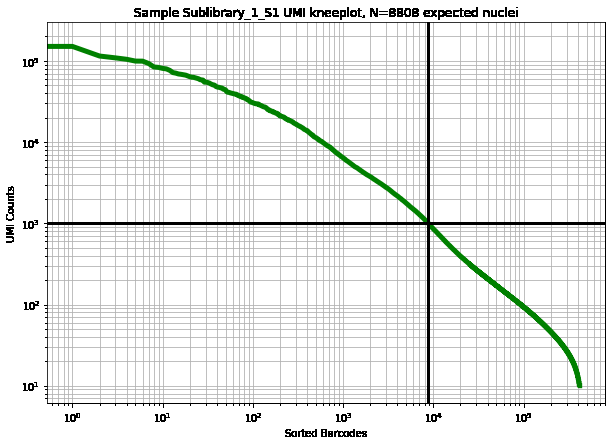

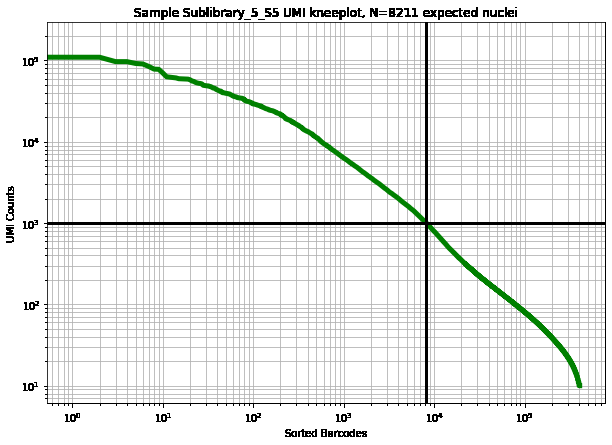

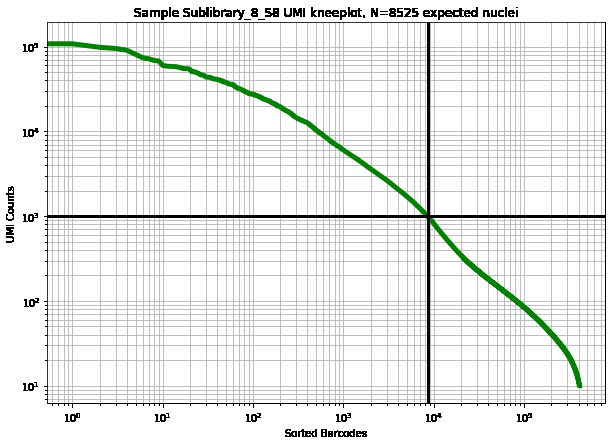

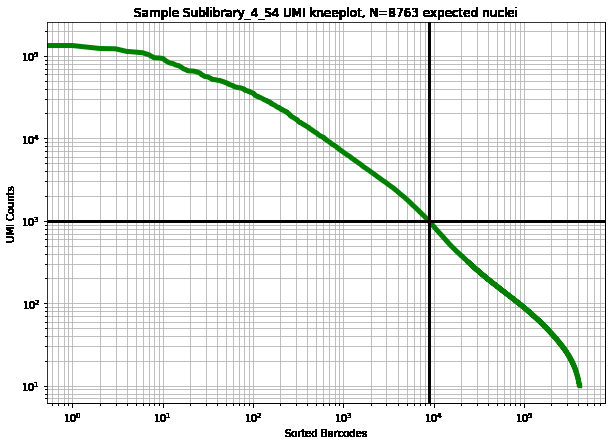

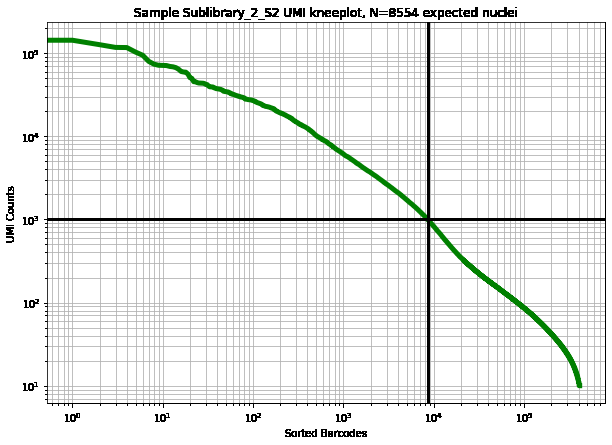

In [13]:
cell_count_thresh = 1000
thresh_dict = {}

# re-format the matrices to work with cellbender:
for cur_dir in sample_dirs:
    
    
    # load the adata:
    adata = sc.read_10x_mtx('{}/all-well/DGE_unfiltered/'.format(cur_dir))
    
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    
    # how many barcodes have the min thresh for a cell?
    n_probable_cells = sum(adata.obs.total_counts >= cell_count_thresh)
    thresh_dict[cur_dir] = n_probable_cells
    
    print(n_probable_cells, 'cells', cur_dir)
    
    # make the kneeplot #########################################################################
    knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]
    fig, ax = plt.subplots(figsize=(10, 7))

    ax.loglog(range(len(knee)), knee, linewidth=5, color="g")
    ax.axhline(y=knee[n_probable_cells], linewidth=3, color="k")
    ax.axvline(x=n_probable_cells, linewidth=3, color="k")

    ax.set_ylabel("UMI Counts")
    ax.set_xlabel("Sorted Barcodes")

    plt.grid(True, which="both")
    plt.title('Sample {} UMI kneeplot, N={} expected nuclei'.format(cur_dir.split('/')[-1], n_probable_cells))

    plt.savefig('{}/all-well/DGE_unfiltered/kneeplot.pdf'.format(cur_dir));
    
    

In [9]:
# write the sublibrary directories to an output file that we can index with our for loop in bash:
pd.Series(sublib_dirs).to_csv('Batch5_sublibrary_dirs.csv', index=False, header=False)

In [14]:
# run the cellbender script:
! bash  /dfs3b/swaruplab/smorabit/data/ADDS_2021/bin/run_cellbender.sh

/dfs3b/swaruplab/smorabit/data/ADDS_2021/analysis/Batch5/Sublibrary_1_S1/all-well/DGE_unfiltered/
cellbender:remove-background: Command:
cellbender remove-background --input /dfs3b/swaruplab/smorabit/data/ADDS_2021/analysis/Batch5/Sublibrary_1_S1/all-well/DGE_unfiltered/ --output /dfs3b/swaruplab/smorabit/data/ADDS_2021/analysis/Batch5/Sublibrary_1_S1/all-well/DGE_unfiltered//cellbender.h5 --expected-cells 10000 --total-droplets-included 25000 --epochs 150 --cuda
cellbender:remove-background: 2021-11-09 22:52:12
cellbender:remove-background: Running remove-background
cellbender:remove-background: Loading data from directory /dfs3b/swaruplab/smorabit/data/ADDS_2021/analysis/Batch5/Sublibrary_1_S1/all-well/DGE_unfiltered/
cellbender:remove-background: CellRanger v2 format
cellbender:remove-background: Trimming dataset for inference.
cellbender:remove-background: Including 38454 genes that have nonzero counts.
cellbender:remove-background: Prior on counts in empty droplets is 35
cellbende

In [15]:
print('done?')

done?


In [2]:
# make a knee plot:

data_dir = "/dfs3b/swaruplab/shared_lab/cross-disorder/count_matrices/AD_Mathys_2019/"

sample_dirs = ['{}{}'.format(data_dir, d) for d in os.listdir(data_dir) if "D17" in d]

# skip the samples that didn't have outputs yet:
sample_dirs = [d for d in sample_dirs if os.path.exists('{}/counts_unfiltered'.format(d))]



In [3]:
cur_dir = sample_dirs[0]
adata = anndata.read_h5ad('{}/counts_unfiltered/adata.h5ad'.format(cur_dir))


/dfs3b/swaruplab/shared_lab/cross-disorder/count_matrices/AD_Mathys_2019/D17-8758
/dfs3b/swaruplab/shared_lab/cross-disorder/count_matrices/AD_Mathys_2019/D17-8759
/dfs3b/swaruplab/shared_lab/cross-disorder/count_matrices/AD_Mathys_2019/D17-8756
/dfs3b/swaruplab/shared_lab/cross-disorder/count_matrices/AD_Mathys_2019/D17-8757
/dfs3b/swaruplab/shared_lab/cross-disorder/count_matrices/AD_Mathys_2019/D17-8765
/dfs3b/swaruplab/shared_lab/cross-disorder/count_matrices/AD_Mathys_2019/D17-8764
/dfs3b/swaruplab/shared_lab/cross-disorder/count_matrices/AD_Mathys_2019/D17-8783
/dfs3b/swaruplab/shared_lab/cross-disorder/count_matrices/AD_Mathys_2019/D17-8782
/dfs3b/swaruplab/shared_lab/cross-disorder/count_matrices/AD_Mathys_2019/D17-8755
/dfs3b/swaruplab/shared_lab/cross-disorder/count_matrices/AD_Mathys_2019/D17-8789
/dfs3b/swaruplab/shared_lab/cross-disorder/count_matrices/AD_Mathys_2019/D17-8788
/dfs3b/swaruplab/shared_lab/cross-disorder/count_matrices/AD_Mathys_2019/D17-8776
/dfs3b/swaruplab

/dfs3b/swaruplab/smorabit/bin/software/miniconda3/envs/CellBender/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


/dfs3b/swaruplab/shared_lab/cross-disorder/count_matrices/AD_Mathys_2019/D17-8762
/dfs3b/swaruplab/shared_lab/cross-disorder/count_matrices/AD_Mathys_2019/D17-8766
/dfs3b/swaruplab/shared_lab/cross-disorder/count_matrices/AD_Mathys_2019/D17-8779
/dfs3b/swaruplab/shared_lab/cross-disorder/count_matrices/AD_Mathys_2019/D17-8778
/dfs3b/swaruplab/shared_lab/cross-disorder/count_matrices/AD_Mathys_2019/D17-8775
/dfs3b/swaruplab/shared_lab/cross-disorder/count_matrices/AD_Mathys_2019/D17-8774
/dfs3b/swaruplab/shared_lab/cross-disorder/count_matrices/AD_Mathys_2019/D17-8769
/dfs3b/swaruplab/shared_lab/cross-disorder/count_matrices/AD_Mathys_2019/D17-8768
/dfs3b/swaruplab/shared_lab/cross-disorder/count_matrices/AD_Mathys_2019/D17-8771
/dfs3b/swaruplab/shared_lab/cross-disorder/count_matrices/AD_Mathys_2019/D17-8770
/dfs3b/swaruplab/shared_lab/cross-disorder/count_matrices/AD_Mathys_2019/D17-8773
/dfs3b/swaruplab/shared_lab/cross-disorder/count_matrices/AD_Mathys_2019/D17-8772
/dfs3b/swaruplab

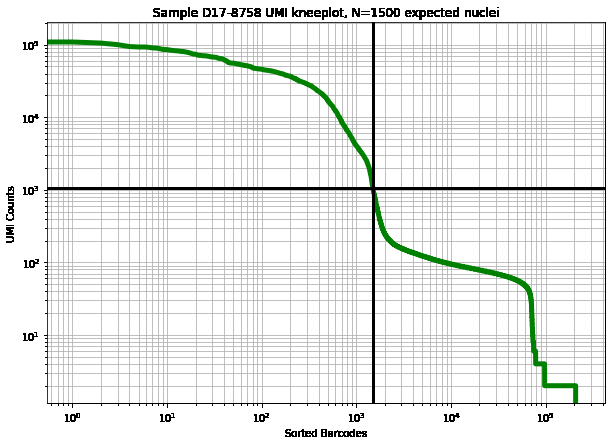

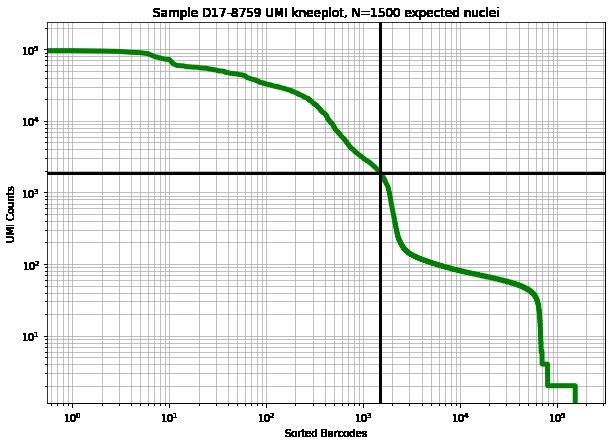

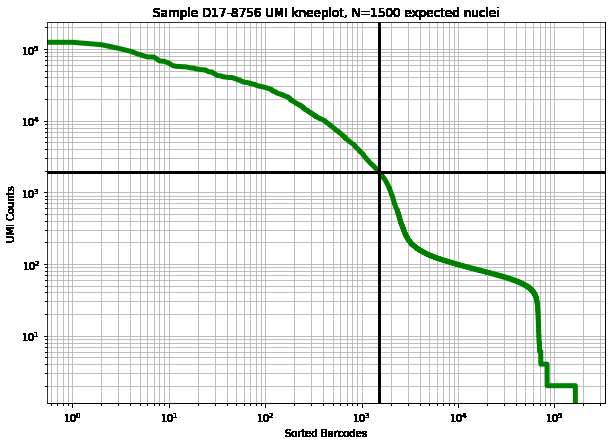

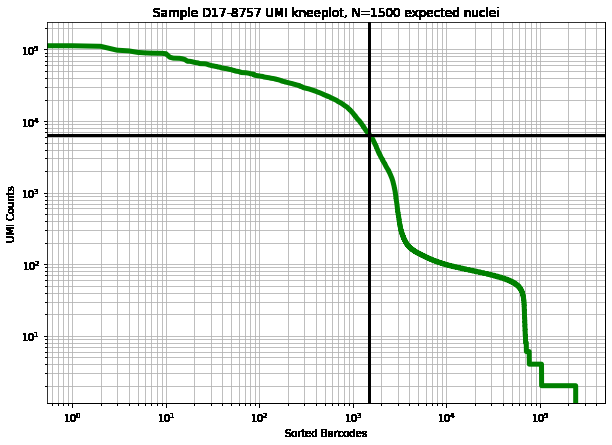

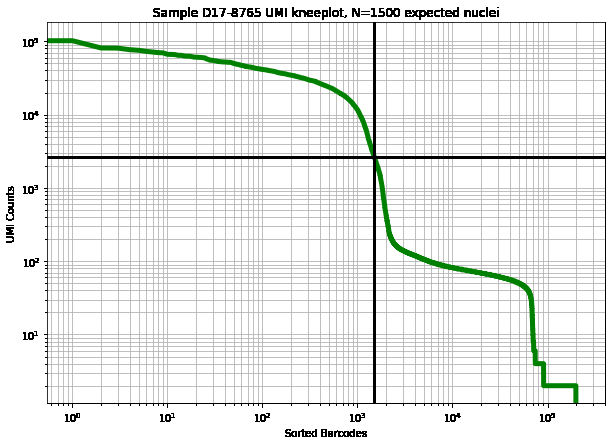

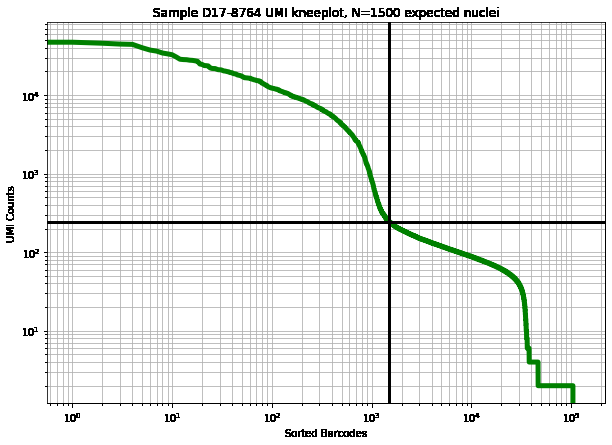

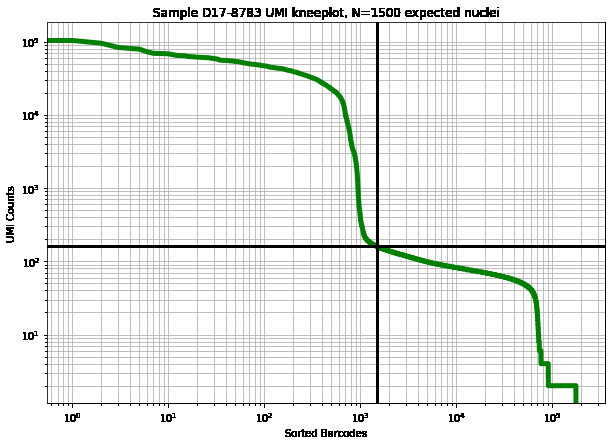

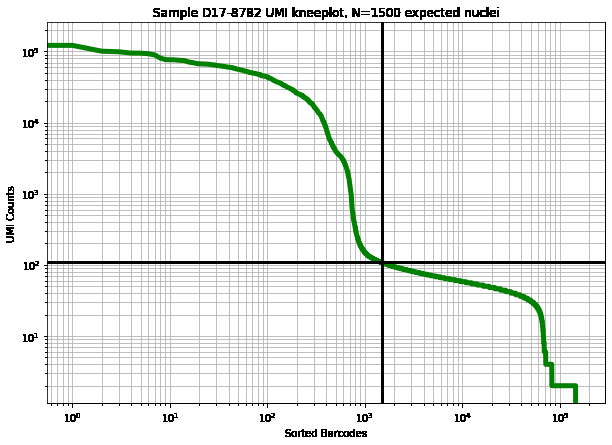

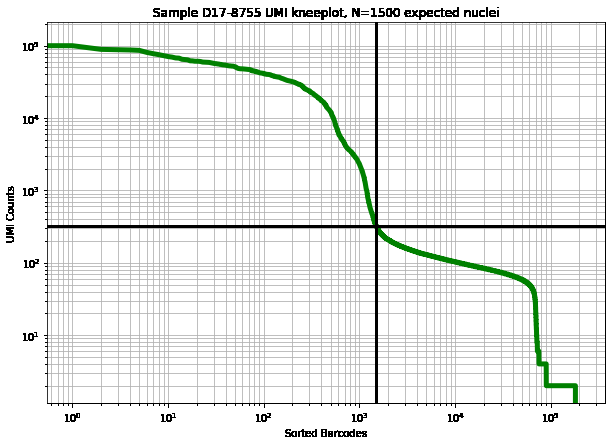

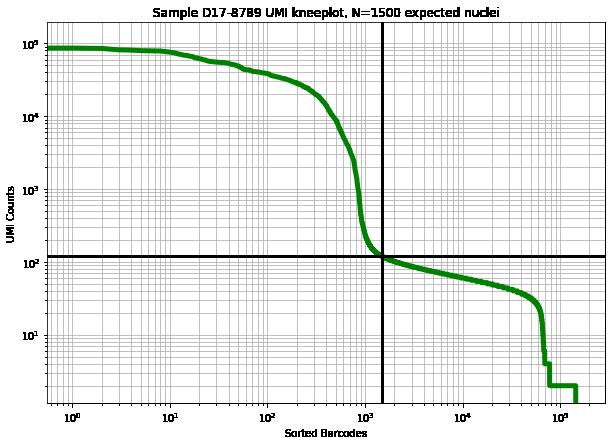

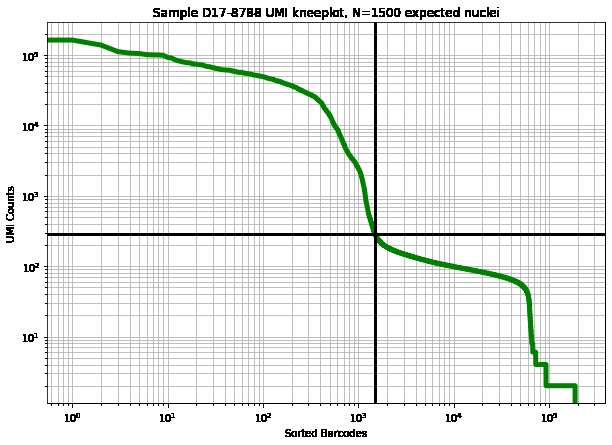

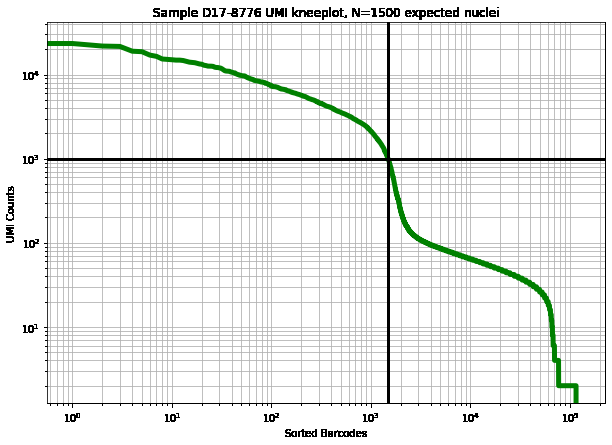

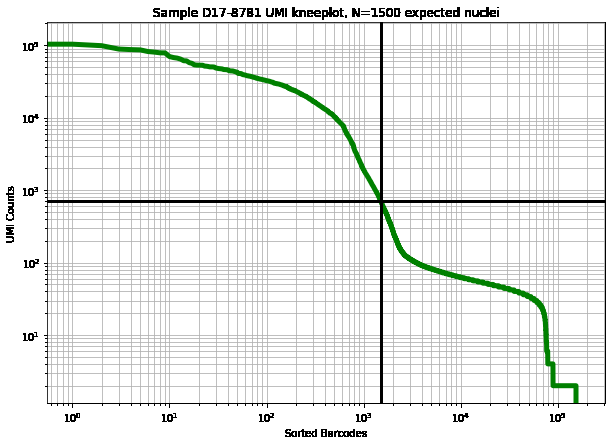

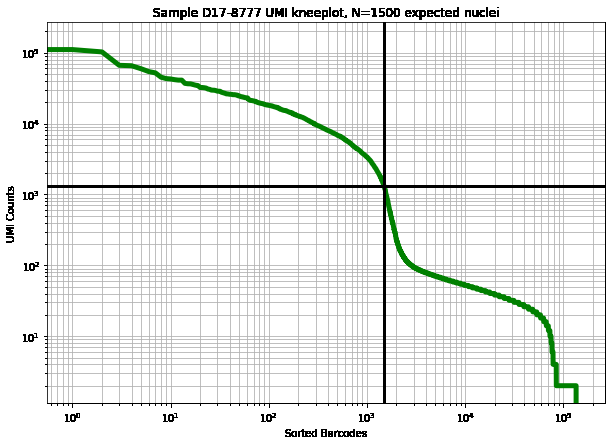

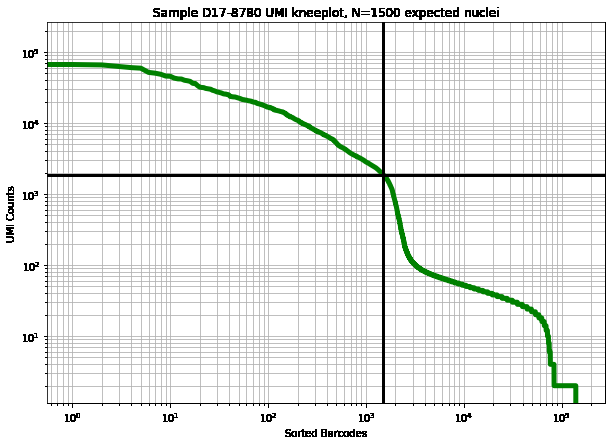

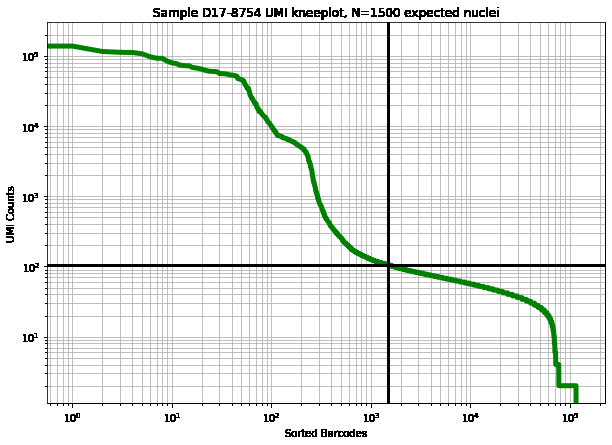

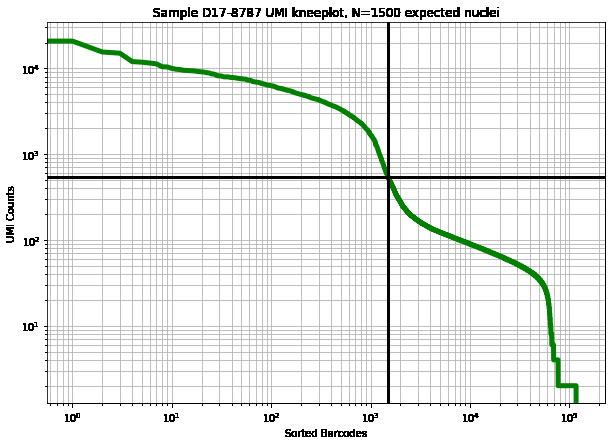

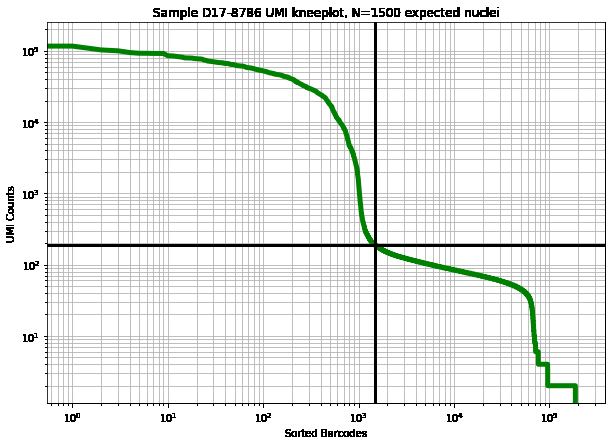

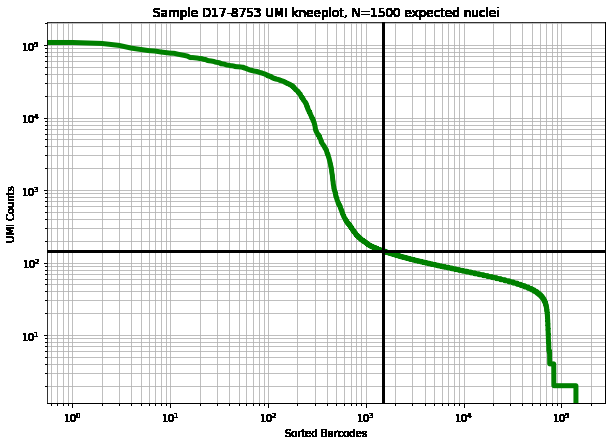

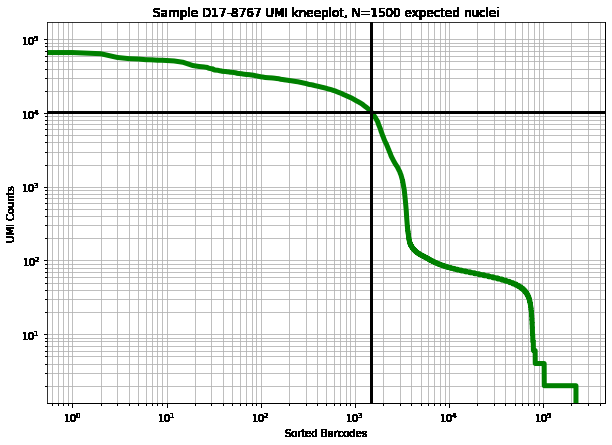

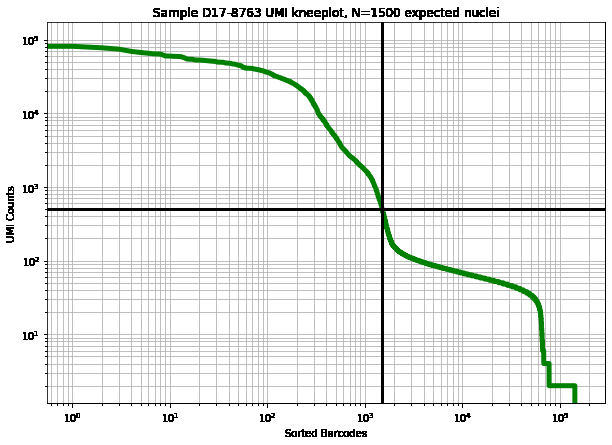

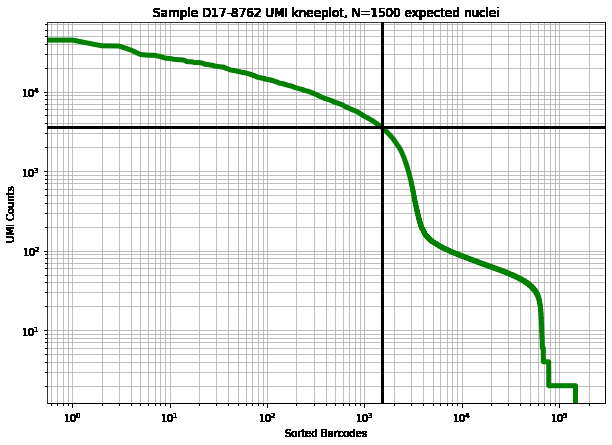

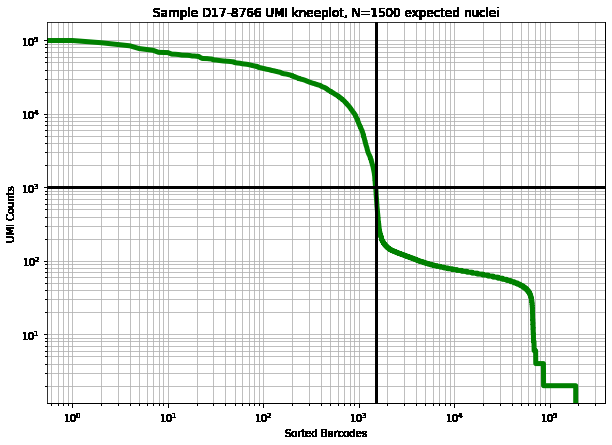

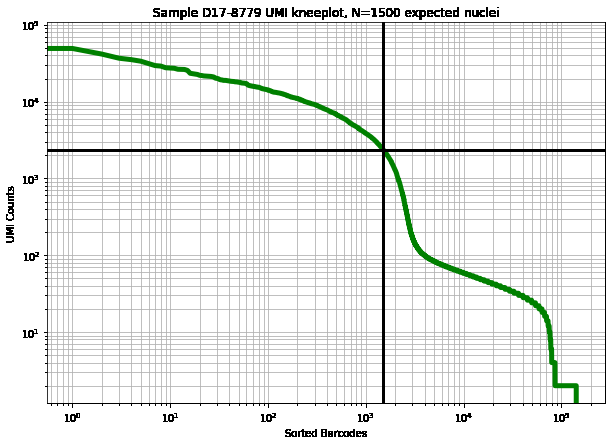

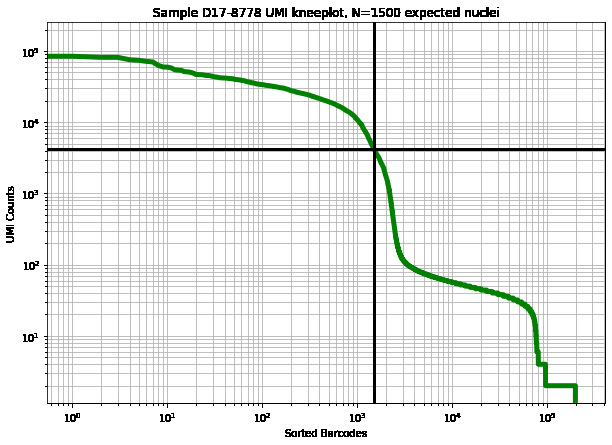

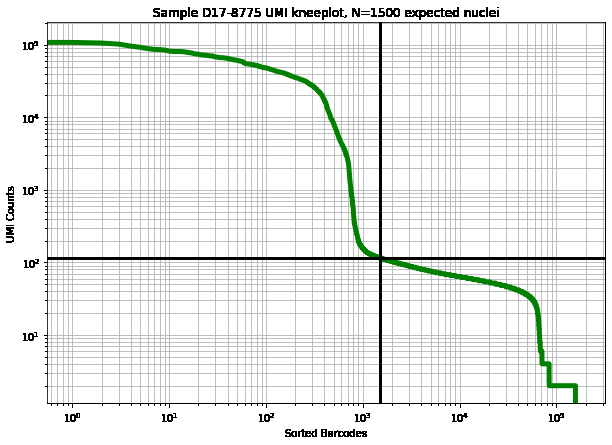

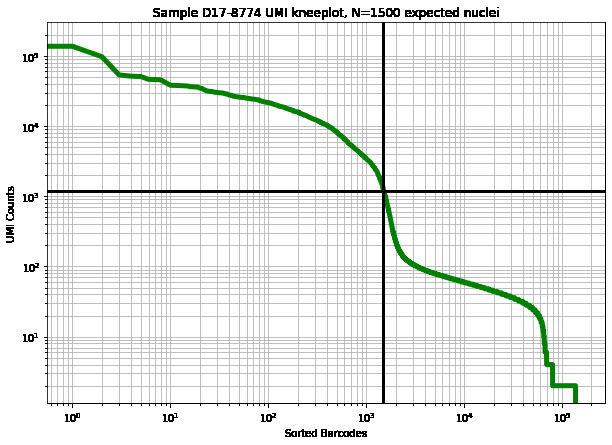

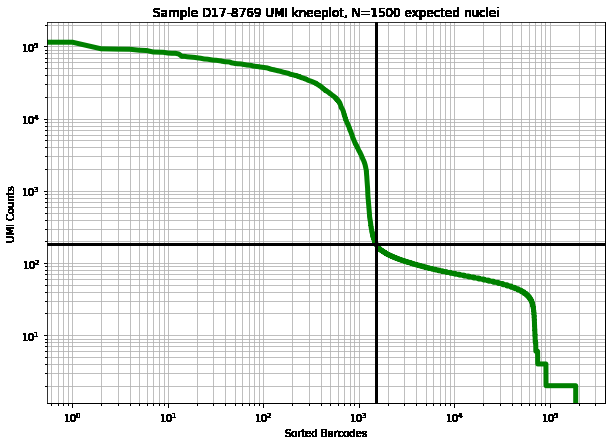

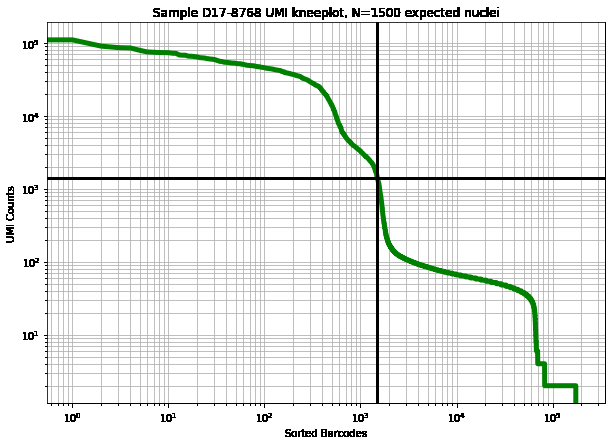

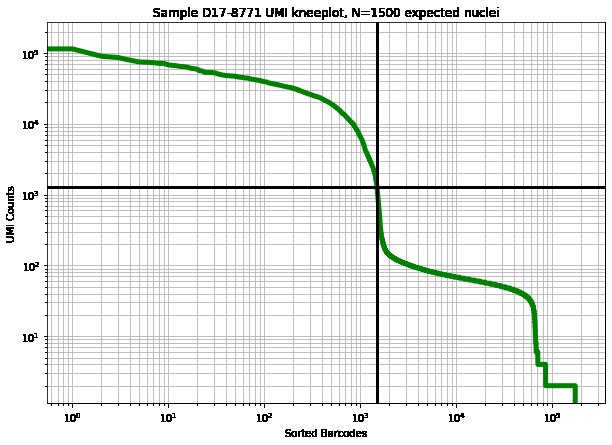

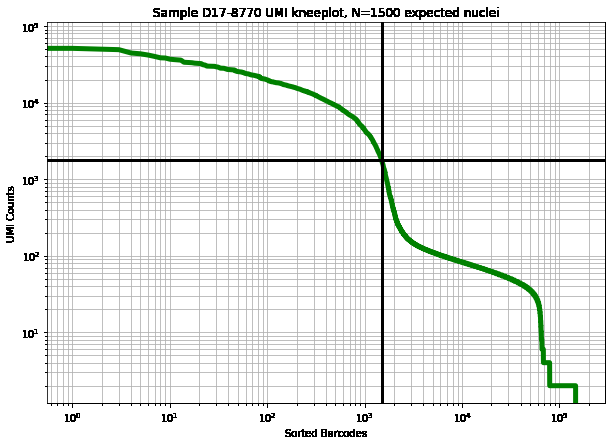

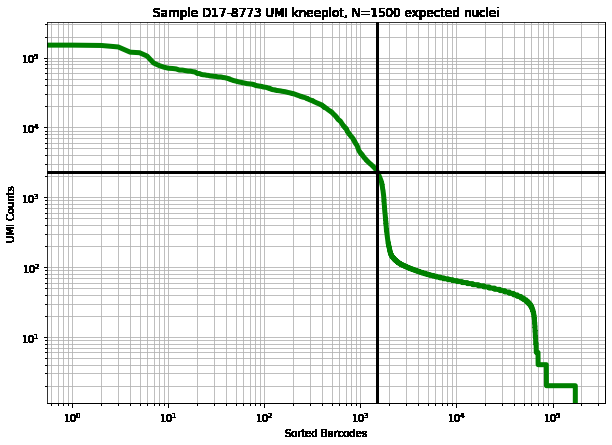

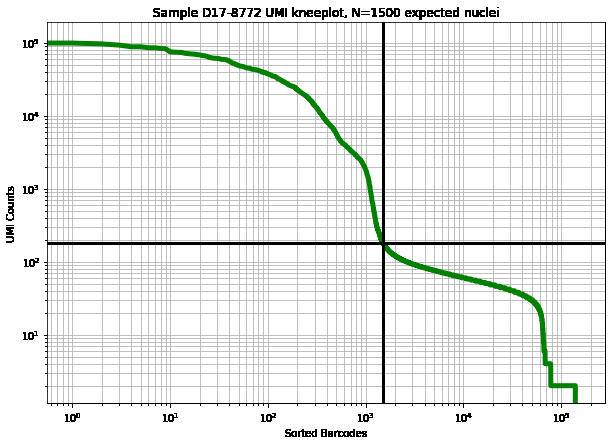

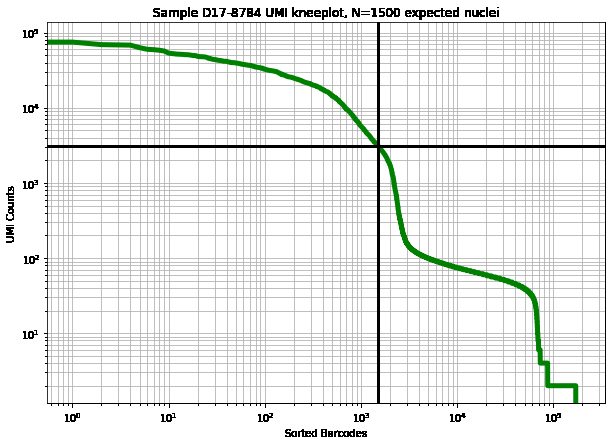

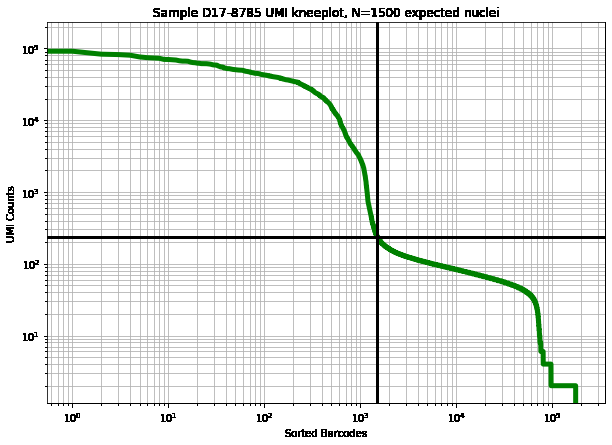

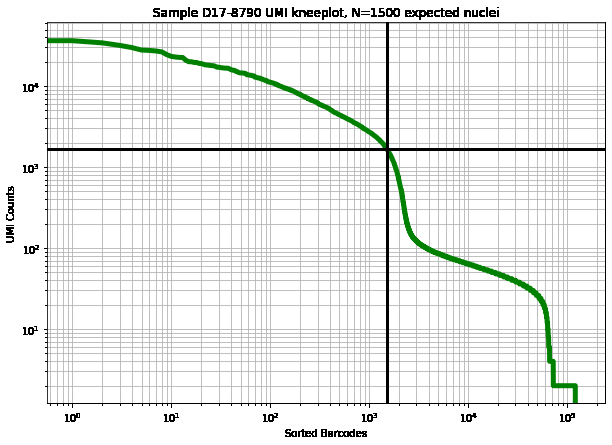

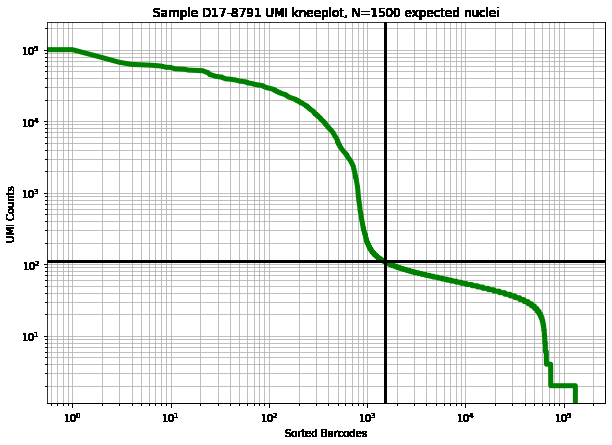

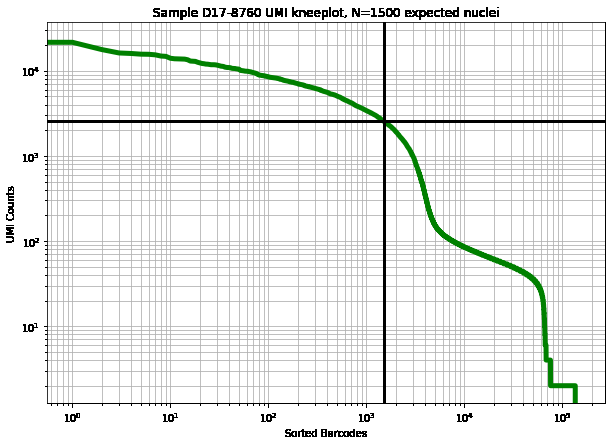

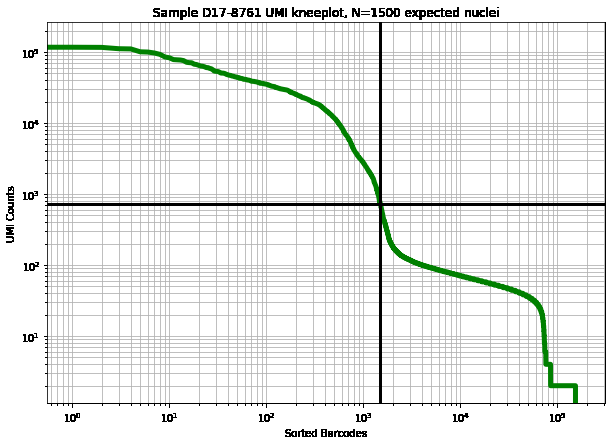

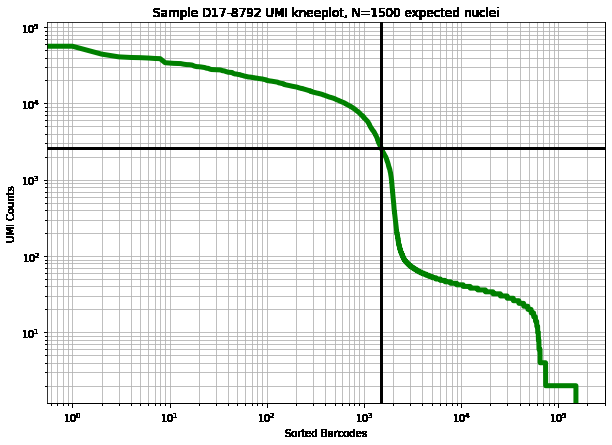

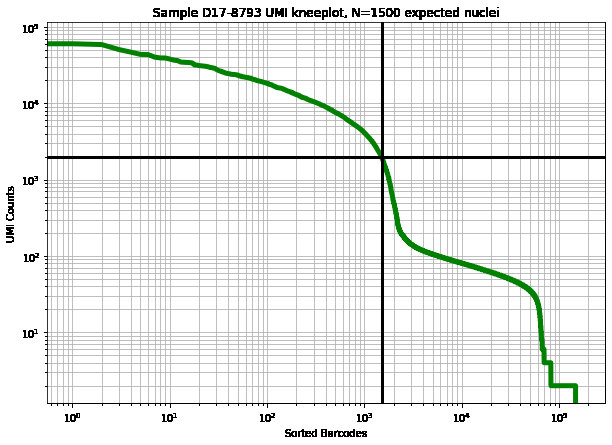

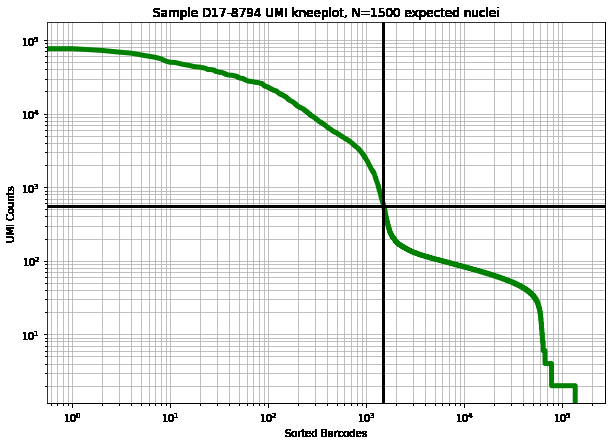

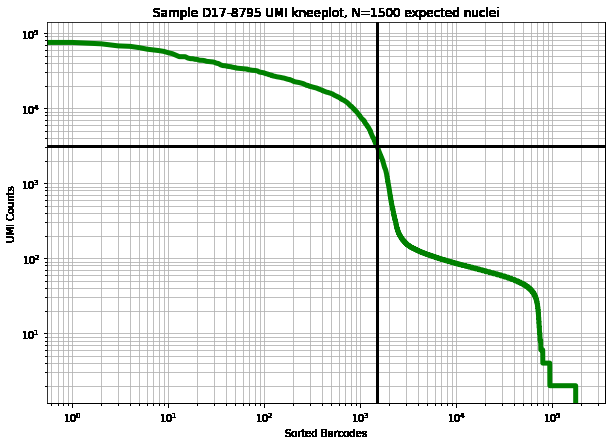

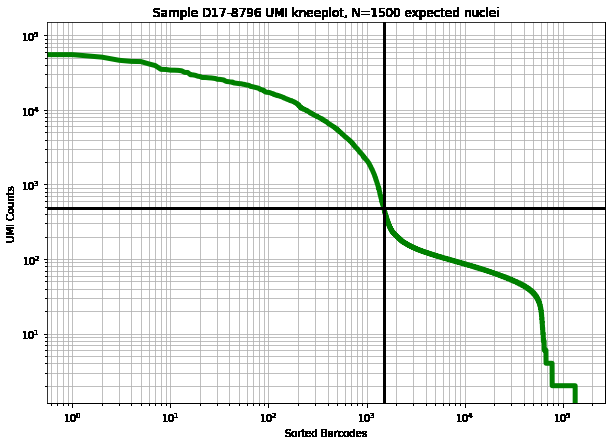

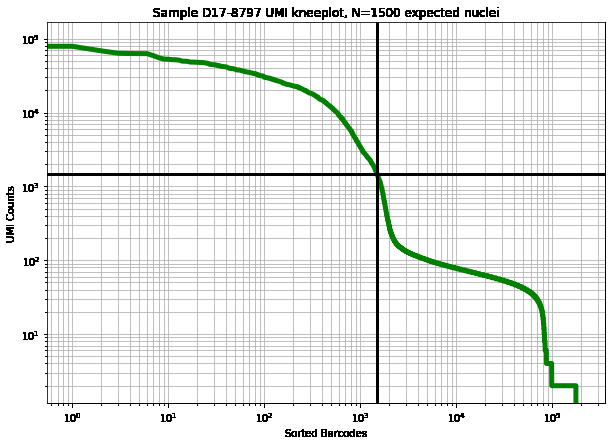

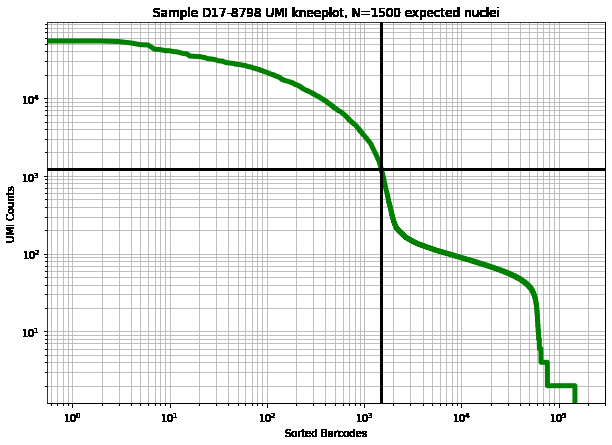

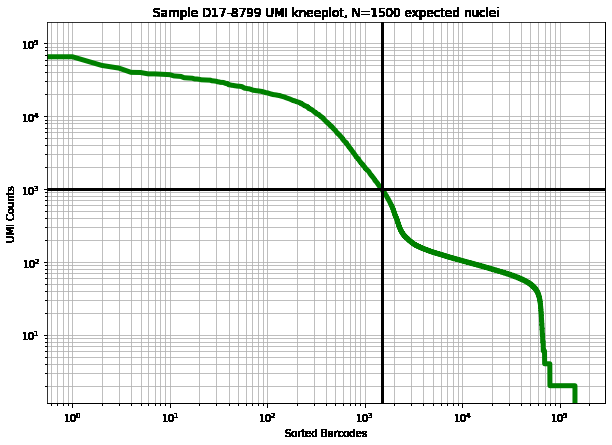

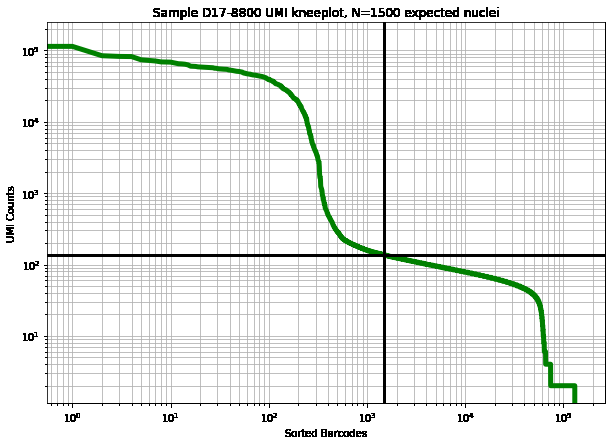

In [22]:
for cur_dir in sample_dirs:
    print(cur_dir)
    adata = anndata.read_h5ad('{}/counts_unfiltered/adata.h5ad'.format(cur_dir))

    knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

    fig, ax = plt.subplots(figsize=(10, 7))

    ax.loglog(range(len(knee)), knee, linewidth=5, color="g")
    ax.axhline(y=knee[expected_num_cells], linewidth=3, color="k")
    ax.axvline(x=expected_num_cells, linewidth=3, color="k")

    ax.set_ylabel("UMI Counts")
    ax.set_xlabel("Sorted Barcodes")

    plt.grid(True, which="both")
    plt.title('Sample {} UMI kneeplot, N={} expected nuclei'.format(cur_dir.split('/')[-1], expected_num_cells))
    #plt.show()

    plt.savefig('{}/counts_unfiltered/kneeplot.pdf'.format(cur_dir))


In [16]:
cur_dir

'/dfs3b/swaruplab/shared_lab/cross-disorder/count_matrices/AD_Mathys_2019/D17-8758'

'D17-8758'

In [32]:
# test loading a whole dataset (Schirmer 2019)

# load samples from cocaine mouse data:
#data_dir = '/dfs3b/swaruplab/shared_lab/cross-disorder/count_matrices/MS_Schirmer_2019/'
#data_dir = '/dfs3b/swaruplab/shared_lab/cross-disorder/count_matrices/PD_Agarwal_2020/'
data_dir = '/dfs3b/swaruplab/shared_lab/cross-disorder/count_matrices/ASD_Velmeshev_2019/'
samples = [s for s in os.listdir(data_dir) if 'SRR' in s]


In [34]:
adata_list = []
for sample in samples:
    try:
        adata = sc.read_h5ad('{}{}/scanpy_preprocessing_cellbender/data/adata_unfiltered.h5ad'.format(data_dir, sample))
    except:
        print('sample', sample, ' error')
        continue
    adata.obs['Sample'] = "Schirmer_2019_" + sample
    
    # apply additional filtering if it's a bad sample
    if sample in bad_samples:
        sc.pp.filter_cells(adata, min_counts = 1000)
        
    adata_list.append(adata)
    
    print(sample, adata.shape)

SRR9262917 (4720, 36601)
SRR9262918 (16310, 36601)
sample SRR9262919  error
SRR9262920 (2261, 36601)
SRR9262921 (5860, 36601)
SRR9262922 (3235, 36601)
SRR9262923 (4846, 36601)
SRR9262924 (3191, 36601)
SRR9262925 (3486, 36601)
SRR9262926 (3349, 36601)
SRR9262927 (2609, 36601)
SRR9262928 (3929, 36601)
SRR9262929 (67743, 36601)
SRR9262930 (4150, 36601)
SRR9262931 (6273, 36601)
SRR9262932 (5889, 36601)
SRR9262933 (7443, 36601)
SRR9262934 (3325, 36601)
SRR9262935 (3189, 36601)
SRR9262936 (5194, 36601)
SRR9262937 (3730, 36601)
SRR9262938 (2750, 36601)
SRR9262939 (46282, 36601)
SRR9262940 (3681, 36601)
SRR9262941 (4996, 36601)
SRR9262942 (3895, 36601)
SRR9262943 (9667, 36601)
SRR9262944 (5899, 36601)
SRR9262945 (4347, 36601)
SRR9262946 (11442, 36601)
SRR9262947 (5226, 36601)
SRR9262948 (1739, 36601)
SRR9262949 (3292, 36601)
SRR9262950 (3848, 36601)
SRR9262951 (3180, 36601)
SRR9262952 (72736, 36601)
SRR9262953 (22354, 36601)
SRR9262954 (2821, 36601)
SRR9262955 (6578, 36601)
SRR9262956 (7171, 3

In [29]:
# combine all adata objects
adata = adata_list[0].concatenate(adata_list[1:])
adata.obs['barcode'] = adata.obs.index

In [30]:
adata.shape

(101791, 36601)